     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 12.0 MB/s eta 0:00:0000:0100:01


/tmp/ipykernel_324/719747984.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap("viridis", 9)


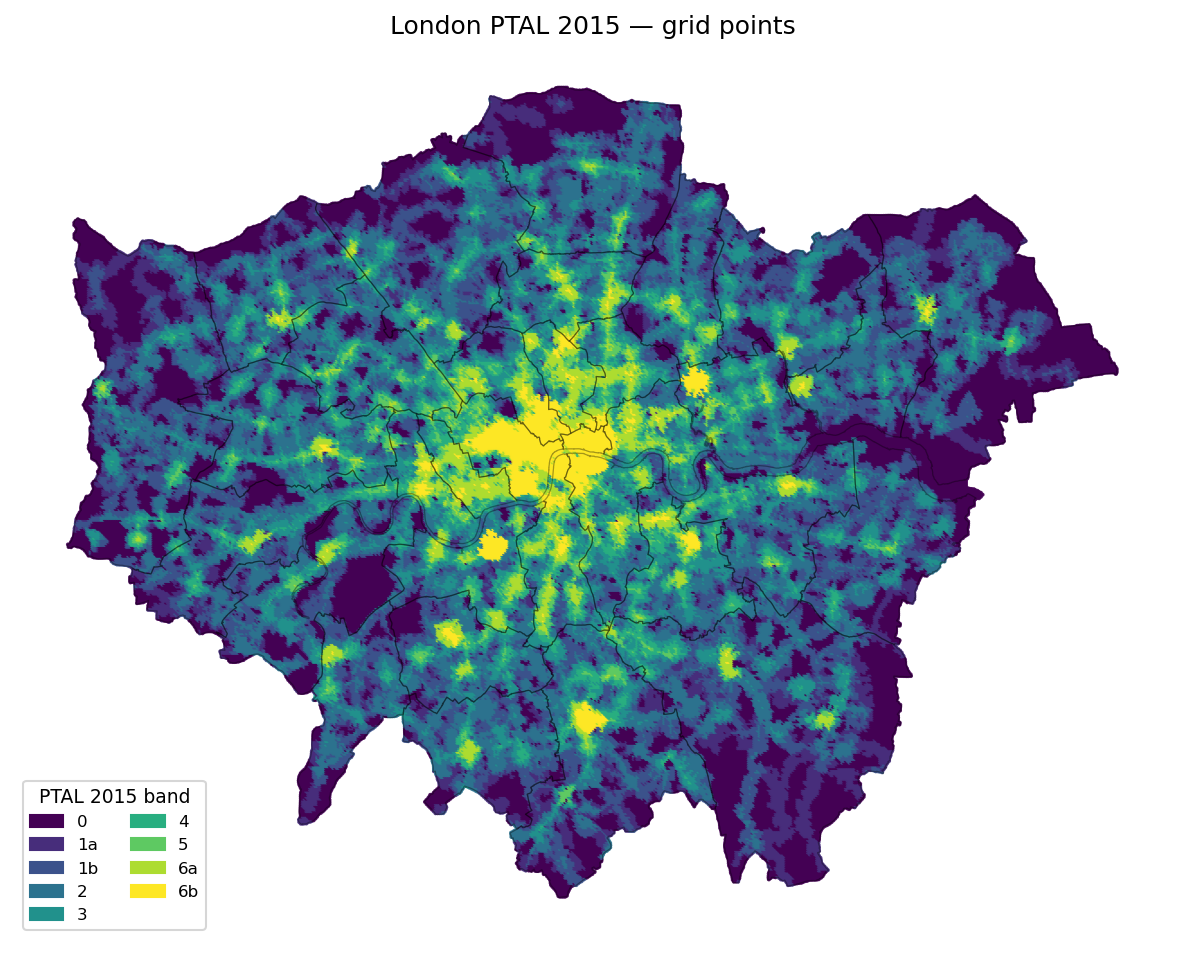

Saved: outputs/figs/london_ptal_2015_grid_points.png
Saved: outputs/figs/london_ptal_2015_grid_points.pdf


In [1]:
!pip install fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

ptal_path = "data/interim/gla_ptal_grid_2015_27700.gpkg"  # 图层名=ptal_grid（Point）
bnd_path  = "data/interim/gla_boroughs_2024_27700.gpkg"   # 可选底图

# --- 读数据 ---
ptal = gpd.read_file(ptal_path, layer="ptal_grid")
ptal = ptal[ptal.geometry.notna()].to_crs(27700)

# 可选底图
try:
    bnd = gpd.read_file(bnd_path).to_crs(27700)
except Exception:
    bnd = None

# --- 准备分类顺序与映射（确保图例顺序稳定）---
order = ["0","1a","1b","2","3","4","5","6a","6b"]
map_num = {"0":0,"1a":1,"1b":2,"2":3,"3":4,"4":5,"5":6,"6a":7,"6b":8}

# 规范化字段并建立数值编码
ptal["band"] = ptal["ptal_2015_band"].astype(str).str.lower().str.strip()
present = [b for b in order if b in ptal["band"].unique()]
ptal["ptal_num"] = ptal["band"].map(map_num).astype(float)

# --- 颜色：用离散色带（ListedColormap + BoundaryNorm）---
# 从默认 'viridis' 取等距颜色（长度按出现的类别也可按全量9级）
base_cmap = plt.cm.get_cmap("viridis", 9)
cmap = ListedColormap([base_cmap(i) for i in range(9)])
bounds = np.arange(-0.5, 9.5, 1.0)  # [-0.5, 0.5, 1.5, ..., 8.5]
norm = BoundaryNorm(boundaries=bounds, ncolors=cmap.N)

# --- 绘图 ---
fig, ax = plt.subplots(figsize=(8, 8), dpi=150)
if bnd is not None:
    bnd.boundary.plot(ax=ax, linewidth=0.6, color="k", alpha=0.35)

x = ptal.geometry.x.values
y = ptal.geometry.y.values
sc = ax.scatter(
    x, y,
    c=ptal["ptal_num"].values,
    s=1, alpha=0.9,
    cmap=cmap, norm=norm,
    rasterized=True
)

# 分类图例（依据 ptal_2015_band）
handles = []
for b in present:
    color = cmap(norm(map_num[b]))
    handles.append(mpatches.Patch(color=color, label=b))
leg = ax.legend(
    handles=handles,
    title="PTAL 2015 band",
    loc="lower left",
    ncol=2,
    frameon=True,
    fontsize=8,
    title_fontsize=9
)

ax.set_title("London PTAL 2015 — grid points")
ax.set_axis_off()
plt.tight_layout()

# --- 保存到 outputs/figs ---
out_dir = Path("outputs/figs")
out_dir.mkdir(parents=True, exist_ok=True)
out_png = out_dir / "london_ptal_2015_grid_points.png"
out_pdf = out_dir / "london_ptal_2015_grid_points.pdf"
plt.savefig(out_png, dpi=300, bbox_inches="tight", facecolor="white")
plt.savefig(out_pdf, bbox_inches="tight", facecolor="white")

plt.show()
plt.close(fig)

print(f"Saved: {out_png}\nSaved: {out_pdf}")

